# Homework 4: Working with data using Pandas, Fitting data with a model, and compartmental models

### <p style="text-align: right;"> &#9989; Lowell Monis


## Goals

The main goals of this homework are 

1. How to model real noisy data.
2. Model selection.
3. Fitting data using `curve_fit`.
4. Solving compartmental models by `solve_ivp`.

To achieve these goals we will be using a dataset; `Credit.csv`

## Assignment instructions

Work through the following assignment, making sure to follow all of the directions and answer all of the questions.

**This assignment is due at 11:59 pm on Friday, March 29.** It should be uploaded into the "Homework Assignments" submission folder for Homework #4.  Submission instructions can be found at the end of the notebook.


##### Grading

* Exploring the credit data (**32 points**)
* Fitting a model to data with `curve_fit` and visualizing the results: (**16 points**)
    - 3.1 Using curve_fit to find best-fit parameters (8 points)
    - 3.2 Using best_fit parameters to calculate the expected model values and plot the expected model values (8 points)
* Modeling a system using `solve_ivp` (**35 points**)
    - 4.1 Use `solve_ivp` to solve the compartmental model (25 points)
    - 4.2 Visualize the numerical solution (10 points)
    

**Total**: 83 points

In [1]:
## Grading 
points_list = [32, 16, 35]

print(f"The total number of points is : {sum(points_list)}")

The total number of points is : 83


---
## Part 1: Exploring the credit data (32 points total)

This problem it will be a little different than what we have done so far. In this problem you will focus on **making decisions and drawing conclusions** and not on coding. As a matter of fact we will provide most of the code. Let's start run the following cell that reads in the `Credit.csv` dataset. Make sure that this notebook and the dataset are in the same folder.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.optimize import curve_fit


sns.set_context('notebook')

# These colors are a personal choice of one of the instructors. 
# You don't have to choose this, you can choose any color scheme you want. 
# If you are interested in knowing more about this color scheme Google "Okabe-Ito color palette"
scolor = ["#CC79A7", "#D55E00", "#0072B2", "#F0E442", "#009E73", "#56B4E9", "#E69F00","#000000"]

In [3]:
# Load the dataset
data_path = 'Credit.csv'

credit_data = pd.read_csv(data_path)

# Display info about the dataset
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         400 non-null    int64  
 1   Income     400 non-null    float64
 2   Limit      400 non-null    int64  
 3   Rating     400 non-null    int64  
 4   Cards      400 non-null    int64  
 5   Age        400 non-null    int64  
 6   Education  400 non-null    int64  
 7   Gender     400 non-null    object 
 8   Student    400 non-null    object 
 9   Married    400 non-null    object 
 10  Ethnicity  400 non-null    object 
 11  Balance    400 non-null    int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 37.6+ KB


In [4]:
credit_data.describe()

,ID,Income,Limit,Rating,Cards,Age,Education,Balance
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,200.500000,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000
std,115.614301,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877
min,1.000000,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000
25%,100.750000,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000
50%,200.500000,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000
75%,300.250000,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000
max,400.000000,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


The dataset contains 400 entries and 12 columns, which include both numerical and categorical variables. Here's a summary of its contents:

#### Numerical Columns:

- **ID**: A unique identifier for each entry. Although numerical, it's essentially a categorical variable because it's used for identification.
- **Income**: Annual income of the individual in thousands of dollars. (Continuous)
- **Limit**: Credit limit. (Continuous)
- **Rating**: Credit score. (Continuous)
- **Cards**: Number of credit cards the individual has. (Discrete)
- **Age**: Age of the individual. (Discrete)
- **Education**: Number of years of education. (Discrete)
- **Balance**: Average credit card **debt** in dollars. (Continuous)

#### Categorical Columns:

- **Gender**: Gender of the individual (Male, Female).
- **Student**: Whether the individual is a student (Yes, No).
- **Married**: Marital status (Yes, No).
- **Ethnicity**: Ethnicity of the individual (_e.g._, Caucasian, Asian, African American).


The dataset does not have no missing values in any of the columns. The numerical features have varying ranges, for example, `Income` ranges approximately from 10.354 to 186.634 (in thousands of dollars), while `Balance` varies from 0 to 1999 dollars. The categorical features include personal attributes like `Gender`, `Student`, `Married`, and `Ethnicity`.

This dataset is well-suited for exploring relationships between individual characteristics and financial behaviors, such as how income, credit rating, or being a student might influence credit card balance. ​

**The goal of this problem is to find the factor(s) (_i.e._ column(s)) that best predict the amount of credit card debt of a person (`Balance`) and to model their relationship.**

### Exploratory Data Analysis (EDA) (20 points)

Our final goal is to find the column that can best predict the credit card debt of a person. So let's use a correlation matrix to find the pair of columns that correlate the most with each other. 

The next code cell drops the `ID` column from the dataset. I do this because the `ID` is just an identifier (could be used as the index). The code then calculates the correlation matrix of the remaining dataset and plots it using `seaborn` heatmap. Note that I am using only the numerical data and not the categorical columns. Furthermore, pay close attention at how I plot the correlation matrix, specifically how I plot only the lower part of the matrix and not the whole thing.

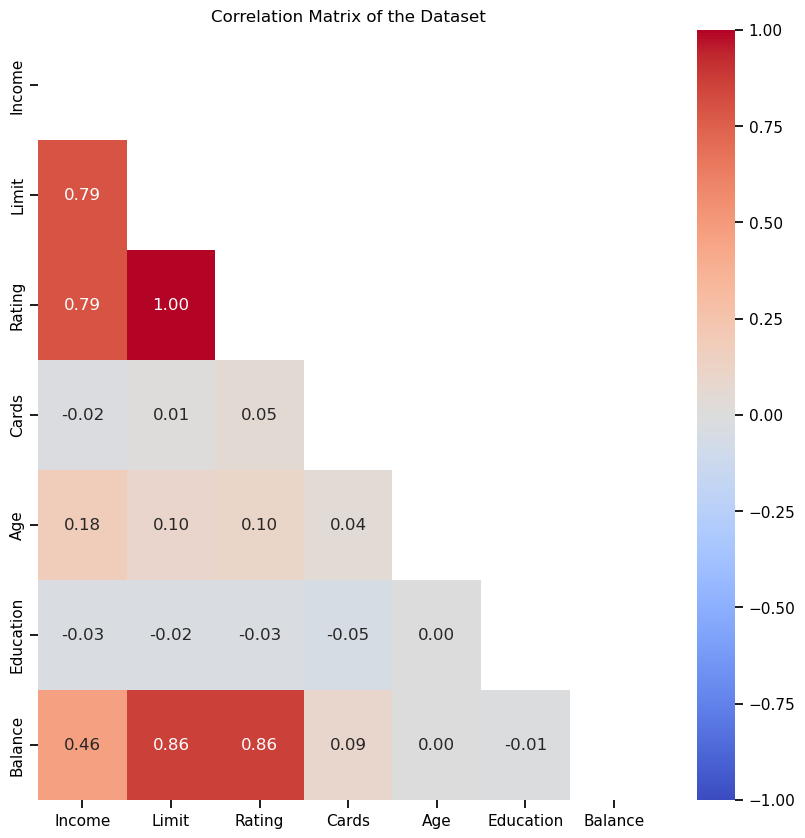

In [5]:
# Drop unwanted columns
credit_df = credit_data.drop(["ID",], axis = 1)
# Calculate the correlation matrix
corr_matrix = credit_df.corr(numeric_only = True)

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plotting the correlation matrix using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, 
                         annot=True, # put the correlation coefficient in the plot
                         vmin = -1, vmax = 1, # set the limits equal for all the plots
                         fmt=".2f", # only 2 decimal digits
                         cmap='coolwarm', # color map
                         mask=mask # plot only the off-diagonal elements of the correlational matrix.
           )
plt.title('Correlation Matrix of the Dataset')
plt.show()


&#9989; **Question 1.1 (4 points)**

1. What are the three pairs that correlate the most?
2. Do you think that education level, number of cards, and age are good predictors of credit card debt? Explain.
3. Do you think that it is surprising that the card limit and credit score have a perfect correlation? Explain.
4. How about card debt and people's income? Explain.

<font size=8 color="#009600">&#9998;</font>

1. Limit-Rating, Limit-Balance, Rating-Balance
2. As per the correlation matrix, these factors are not the best predictors of credit card debt. However, these are discrete forms of data, and since the data is discrete, the correlation matrix may not give the best idea of the ability fo these fields to predict credit card debt. Moreover, I feel that these fields are rather qualitative in nature, and things like expenditure and income may play a more direct role rather than education level, age, and the number of cards.
3. It is not surprising to me: the usage limit is directly related to one's credit score. The more a person's credit score, the higher the trust the bank has in them, and the higher their credit limit.
4. The correlation between income and credit card debt is minimal, but existent. Generally, credit card debt has a direct relation with income, but this isolated relation between two variables, without accommodating for other factors, does not really guarantee a direct relation between the two factors in question. For example, things like expenditure is not accounted for. A person with a high income can have high credit card debt if they have many dependents or a lot of expenditures. There are many such outlier cases. But generally, it makes sense for one to assume a direct relation between debt and income.

As mentioned the correlation matrix is a good way to find correlated variables, but it is always good to check with visualization. The next code cell makes scatter plots between all the pairs of columns above. [Here](https://seaborn.pydata.org/generated/seaborn.pairplot.html) is the documentation of `pairplot`, you should read it and play around with it. 

C:\Users\lowel\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


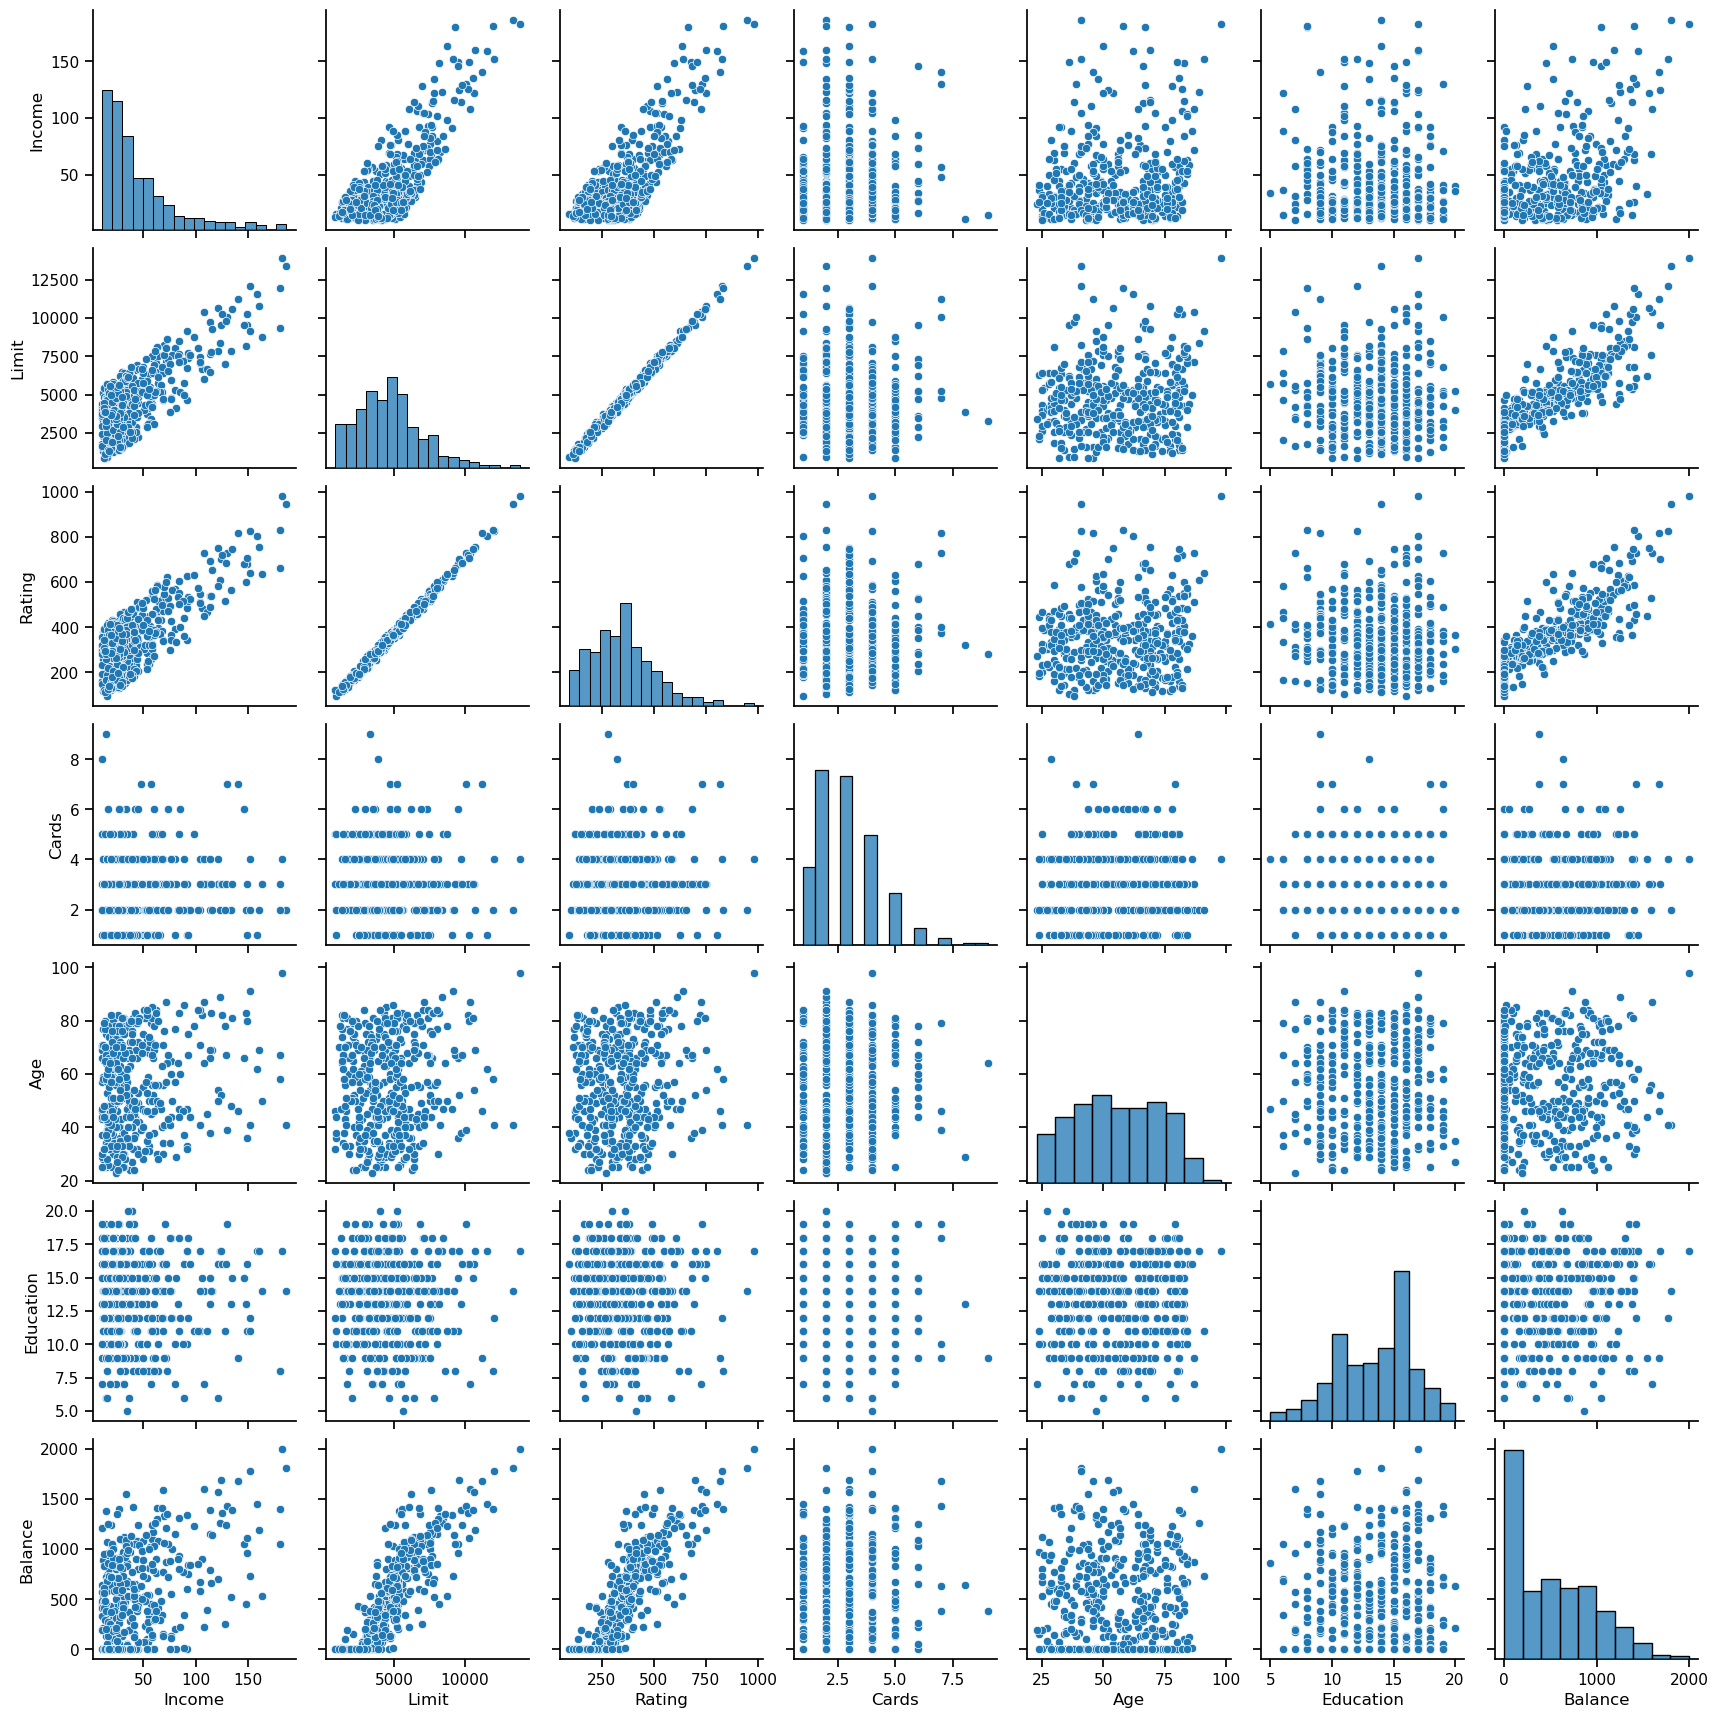

In [6]:
# Drop the categorical columns from the dataset
numerical_df = credit_data.drop(columns=['ID', 'Gender', 'Student', 'Married', 'Ethnicity'])

# Create pair plot
# plt.figure( figsize = (21,21))
sns.pairplot(numerical_df)
# Note: This plot might take a while to be displayed, so be patient

&#9989; **Question 1.2 (16 points)** Describe what you see. In particular, 

1. (2 points) Do you see any pattern in the plots? 
2. (3 points) What are your conclusion about using education level, number of credit cards, and age? Do you think that any of the three is a factor on the amount of debt a person would have?
3. (1 points) What do the plots in the diagonals represent?
4. (2 points) What type of mathematical relationship do you predict between `Limit` and `Rating`? Explain
5. (2 points) between `Balance` and `Limit` and between `Balance` and `Rating`? Explain
6. (3 points) Which one do you think is a better descriptor of credit card debt; credit score or credit limit? 
7. (3 points) What do those points at Balance = 0 in the plot Balance vs Limit (Balance vs Rating) mean?

<font size=8 color="#009600">&#9998;</font> **Answer:**

1. Yes. There are many observable patterns which can tell a lot about the data being represented. There is the case of the Limit-Rating relation with the perfect linearity, thus being represented by a straight line. Similarly, like previously explained, there is a general linear relationship between balance and income, but there are multiple outliers. All plots are repeated due to the fact that the factors get matched twice on both axes. The diagonal is composed of barplots due to the fact that it is the same variable being matched on both axes.
2. My thoughts about the nature of the data in these cases being discrete are paralleled here. There is a sort of equilateral spacing between the data points, or streams of data points. More importantly, however, the data is scattered across the plane, paralleling my conclusion that there is no quantifiable relation between these factors and the credit card debt, at least in the scope of the given data.
3. On the diagonals, data is being plotted in the order and in the reverse order of arrangement in the dataset. In other words, the same factors are being plotted against each other resulting in bar graphs on one diagonal. The other diagonal is a result of the factors on one of the axes being plotted in reverse order. The correlation between the bar plot diagonal is a perfect 1.0.
4. If $x =$ Limit; $y =$ Rating: I would predict the relation to be $y = x$. This is because of the near perfect line formed by the data-points on the scatter plot, indicating a nearly perfectly linear relationship. The correlation matrix returning a 1.0 is additional evidence to this relationship. Essentially, the value of the rating is the same as the value of the credit card limit.
5. Both balance and limit, and balance and rating have the same plot, and the same correlation coefficient. Since the correlation coefficient was 0.86, I predict for $y =$ Balance, and $x$ being the other predictor, that $y = 0.86x$ for a line of best fit. There are a few outliers, leading to a lesser than perfect coefficient. Additionally, the reason why the plots are the same is because of the perfectly linear relation between the rating and limit. Essentially, in both the plots, the balance is being plotted against the exact same set of values.
6. To me, within the scope of this data, quantitavely, both are equally good predictors. Qualitatevely, I would stick with the credit score due to my lack of understanding in financial matters, since it is a summary of credit for a person's entire financial history. Until I confirm for myself that the credit limit is exactly the same as the credit score, and not generally based on the credit score, I would prefer to use the credit score over the limit. But quantitavely, it does not make a difference which I would use, at least within the scope of this data.
7. These are probably the people who are absolutely ruining our chances of getting a 1.0 correlation coefficient. These are the people with no credit card debt, i.e., people who have paid their bills across a whole range of credit limits, or have not used their card(s) at all. This is why the limit and credit score, while good predictors of debt, are not perfect predictors of credit card debt.

### Modeling

&#9989; **Read this** Based on the above plots and on the answers to the questions I decide to find the relationship between `Balance` and `Rating`. What equation should we fit? Well, we don't know a priori, but the plots indicate a linear relationship to start. Moving up the ladder of equations, the next step would be a polynomial, but what order? What about exponential? or even square roort? or sinusoidal? Well, definitely not sinusoidal because there is no repetition.

The next code cells create three functions that will be used in `curve_fit` to find the best fit. The mathematical equations for the three code functions are 

- Linear: $$ B = a + bR$$

- Cubic: $$ B = a + b R + c R^2 + d R^3$$

- Squared root: $$ B = a + b  \sqrt{R}$$

If you are interested to explore other options you can add your own function at the end of the next code cell.
  

In [7]:
def linear_eq(x, a, b):
    """
    Calculate the value of a linear equation y = a + bR.

    Args:
        x (float): The value of the independent variable.
        a (float): The constant term in the linear equation.
        b (float): The coefficient of x in the linear equation.

    Returns:
        float: The value of the linear equation y = ax + b, evaluated at the given x.
    """
    y = a + b * x
    return y


def cubic_eq(x, a, b, c, d):
    """
    Calculate the value of a cubic equation y = a + b*x + c * x^2 + d * x^3.

    Args:
        x (float): The value of the independent variable.
        a (float): Coefficient of the bias term.
        b (float): Ceofficient of the linear term.
        c (float): Coefficient of the quadratic term.
        d (float): Coefficient of the cubic term.

    Returns:
        float: The value of the cubic equation, evaluated at the given x.

    """
    y = 0
    coeff = [a, b, c, d]
    for i in range(len(coeff)):
        # Iterate through the coefficients and calculate the corresponding term
        y += coeff[i] * x ** i

    return y

def sqrt_eq(x, a, b):
    """
    Calculate the value of a linear equation y = a + bR.

    Args:
        x (float): The value of the independent variable.
        a (float): The constant term in the linear equation.
        b (float): The coefficient of x in the linear equation.

    Returns:
        float: The value of the linear equation y = ax + b, evaluated at the given x.
    """
    y = a + b * np.sqrt(x)
    return y


&#9989; **Read this** Now it is time to fit the equations to the data and find which one is better.

Linear Fit Parameters: a = -3.91e+02, b = 2.57e+00
Cubic Fit Parameters: a = -4.58e+02, b = 2.66e+00, c = 9.16e-04, d = -1.40e-06


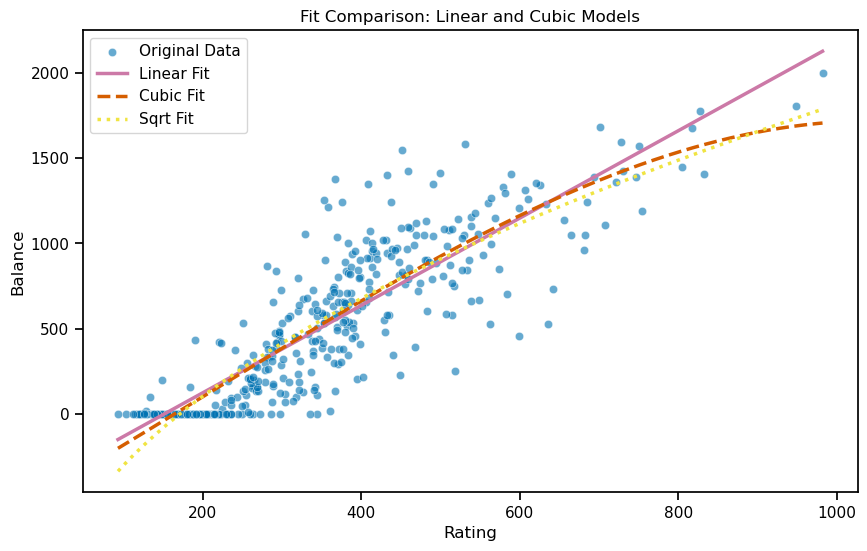

In [8]:
# Extract x and y data
xdata = credit_data['Rating'].values
ydata = credit_data['Balance'].values

# Fit the models
linear_params, _ = curve_fit(linear_eq, xdata, ydata)
cubic_params, _ = curve_fit(cubic_eq, xdata, ydata)
sqrt_params, _ = curve_fit(sqrt_eq, xdata, ydata)

# Sort the x values for predictions by creating a new range
x_fit = np.linspace(xdata.min(), xdata.max(), len(xdata))

# Calculate fitted y values
y_linear_fit = linear_eq(x_fit, *linear_params)
y_cubic_fit = cubic_eq(x_fit, *cubic_params)
y_sqrt_fit = sqrt_eq(x_fit, *sqrt_params)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Rating', y='Balance', data=credit_data, color = scolor[2], alpha=0.6, label='Original Data')
plt.plot(x_fit, y_linear_fit,  linestyle = '-', linewidth =2.5, color=scolor[0], label='Linear Fit')
plt.plot(x_fit, y_cubic_fit,  linestyle = '--', linewidth =2.5, color= scolor[1], label='Cubic Fit')
plt.plot(x_fit, y_sqrt_fit,  linestyle = ':', linewidth = 2.5, color=scolor[3], label='Sqrt Fit')
plt.xlabel('Rating')
plt.ylabel('Balance')
plt.title('Fit Comparison: Linear and Cubic Models')
plt.legend()


# Print out the parameters
print("Linear Fit Parameters: a = {:.2e}, b = {:.2e}".format(*linear_params))
print("Cubic Fit Parameters: a = {:.2e}, b = {:.2e}, c = {:.2e}, d = {:.2e}".format(*cubic_params))


### Model Selection (12 points)

&#9989; **Read this** Now that we have fitted how curves; Which one is the best fit? In Day 15 assignments you explored different options for deciding the best fit. Some of you have suggested to calculate the mean squared error (MSE), some the root mean squared error (RMSE), some the mean absolute error (MAE), some the R-squared coefficients. Let's calculate all of those.

The next code cells provide code that defines all of the above functions, calculate all of the above metrics (except MSE which nothing else than RMSE$^2$) and display all those numbers into a nice table using `heatmap`

In [9]:
def calculate_r_squared(y_true, y_pred):
    """
    Calculate R-squared score.

    Parameters:
    - y_true: array-like, true target values.
    - y_pred: array-like, predicted target values by the regression model.

    Returns:
    - R-squared value.
    """
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

def calculate_mse(y_true, y_pred):
    """
    Calculate Mean Squared Error (MSE).

    Parameters:
    - y_true: array-like, true target values.
    - y_pred: array-like, predicted target values by the regression model.

    Returns:
    - Mean Squared Error value.
    """
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

def calculate_mae(y_true, y_pred):
    """
    Calculate Mean Absolute Error (MAE).

    Parameters:
    - y_true: array-like, true target values.
    - y_pred: array-like, predicted target values by the regression model.

    Returns:
    - Mean Absolute Error value.
    """
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

def calculate_rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE).

    Parameters:
    - y_true: array-like, true target values.
    - y_pred: array-like, predicted target values by the regression model.

    Returns:
    - Root Mean Squared Error value.
    """
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse

In [10]:
# Calculate RMSE for each fit
rmse_linear = calculate_rmse(ydata, y_linear_fit)
rmse_cubic = calculate_rmse(ydata, y_cubic_fit)
rmse_sqrt = calculate_rmse(ydata, y_sqrt_fit)

# Calculate MAE for each fit
mae_linear = calculate_mae(ydata, y_linear_fit)
mae_cubic = calculate_mae(ydata, y_cubic_fit)
mae_sqrt = calculate_mae(ydata, y_sqrt_fit)

# Calculate R-squared for each fit
r_squared_linear = calculate_r_squared(ydata, y_linear_fit)
r_squared_cubic = calculate_r_squared(ydata, y_cubic_fit)
r_squared_sqrt = calculate_r_squared(ydata, y_sqrt_fit)


# # Print the results including MAE
# print(f"Linear Fit - R²: {r_squared_linear:.4f}, RMSE: {mse_linear:.4f}, MAE: {mae_linear:.4f}")
# print(f"Cubic Fit - R²: {r_squared_cubic:.4f}, RMSE: {mse_cubic:.4f}, MAE: {mae_cubic:.4f}")
# print(f"sqrt Fit - R²: {r_squared_sqrt:.4f}, RMSE: {mse_sqrt:.4f}, MAE: {mae_sqrt:.4f}")


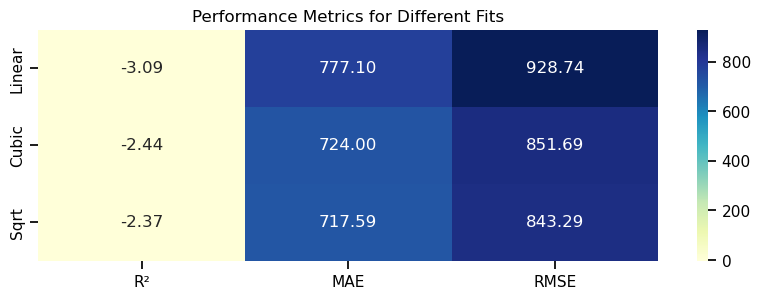

In [11]:
# Prepare the data for the heatmap
metrics_data = {
    'R²': [r_squared_linear, r_squared_cubic, r_squared_sqrt],
    'MAE': [mae_linear, mae_cubic, mae_sqrt],
    'RMSE': [rmse_linear, rmse_cubic, rmse_sqrt]
}
metrics_df = pd.DataFrame(metrics_data, index=['Linear', 'Cubic', 'Sqrt'])

# Plotting the heatmap
plt.figure(figsize=(10, 3))
sns.heatmap(metrics_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Performance Metrics for Different Fits')
plt.show()

&#9989; **Questions 1.3 (6 points)**
1. (2 points) What does a negative R squared value mean? Search the internet if you need to.
2. (1 points) What do the value of MAE and RMSE mean with respect to credit card debt?
3. (3 points) Which fit do you think is best after looking at the table? Explain

<font size=8 color="#009600">&#9998;</font> **Answer:**

1. A negative R-squared is essentially when a line of best fit, is not exactly a line of best fit. It is basically when the model fits the data poorly, worse than even a horizontal line. [Source](https://towardsdatascience.com/explaining-negative-r-squared-17894ca26321)
2. The lesser the value of the errors, the greater the accuracy of the model. The more the error, the less accurate the model.In this case, the values of the errors indicate that the number of outliers are extremely high in the data, with respect to the models in question. The residual values of the data is also pretty high when one takes a look at the plot. This means that the credit card debt is really scattered around the plot, with some people having none, while the majority having debt scattered away from the expected debt corresponding with their credit scores. There are other outlying factors affecting the true debt of these individuals, that are not considered. So why there is a good relation between the quantifiers, it cannot be modeled by straightforward models like these.
3. In all sincerity, they are all terrible. But based on our indicators, the squared root equation has the least negative $R^2$, and the least mean absolute and root mean square errors as compared to the rest. Thus, I would go with the squared root equation.

&#9989; **Read this** Metrics like those above are very useful for quantification, however, they can be skewed and give you the wrong impression. Another way to choose between different models is to divide the data into two or more parts and see how each model performs on each subset. 

The next code cells shuffled the data, then splits the data in half and creates two new datasets called; `subset_1` and `subset_2`. After select the $x$ and $y$ variables we re-fit the models on each subset and compare them again at the end.

In [12]:
# Shuffle the indices of the DataFrame
shuffled_indices = np.random.permutation(credit_data.index)

# Determine the split point for 50% of the data (for example)
split_point = int(len(shuffled_indices) * 0.5)

# Split the indices into training and test sets
train_indices = shuffled_indices[:split_point]
test_indices = shuffled_indices[split_point:]

# Create the training and test DataFrames
subset_1 = credit_data.loc[train_indices]
subset_2 = credit_data.loc[test_indices]

# Now you have two new datasets to play with.

# Extract x and y data for both subsets
xdata1, ydata1 = subset_1['Rating'].values, subset_1['Balance'].values
xdata2, ydata2 = subset_2['Rating'].values, subset_2['Balance'].values

# Fit the linear and cubic models to Subset 1
linear_params1, _ = curve_fit(linear_eq, xdata1, ydata1)
cubic_params1, _ = curve_fit(cubic_eq, xdata1, ydata1)
sqrt_params1, _ = curve_fit(sqrt_eq, xdata1, ydata1)

# Fit the linear and cubic models to Subset 2
linear_params2, _ = curve_fit(linear_eq, xdata2, ydata2)
cubic_params2, _ = curve_fit(cubic_eq, xdata2, ydata2)
sqrt_params2, _ = curve_fit(sqrt_eq, xdata2, ydata2)

# Print the fitting parameters for each model and subset
print("Subset 1 - Linear Fit Parameters:", linear_params1)
print("Subset 1 - Cubic Fit Parameters:", cubic_params1)
print("Subset 2 - Linear Fit Parameters:", linear_params2)
print("Subset 2 - Cubic Fit Parameters:", cubic_params2)


Subset 1 - Linear Fit Parameters: [-357.54709316    2.49815339]
Subset 1 - Cubic Fit Parameters: [-4.90090215e+02  3.26456425e+00 -9.89619675e-04  1.29478130e-07]
Subset 2 - Linear Fit Parameters: [-425.97613877    2.63947863]
Subset 2 - Cubic Fit Parameters: [-1.63106489e+02 -4.74746870e-01  9.77216853e-03 -8.53494059e-06]


&#9989; **Read this** The next code cells plots all the models for the three datasets. 

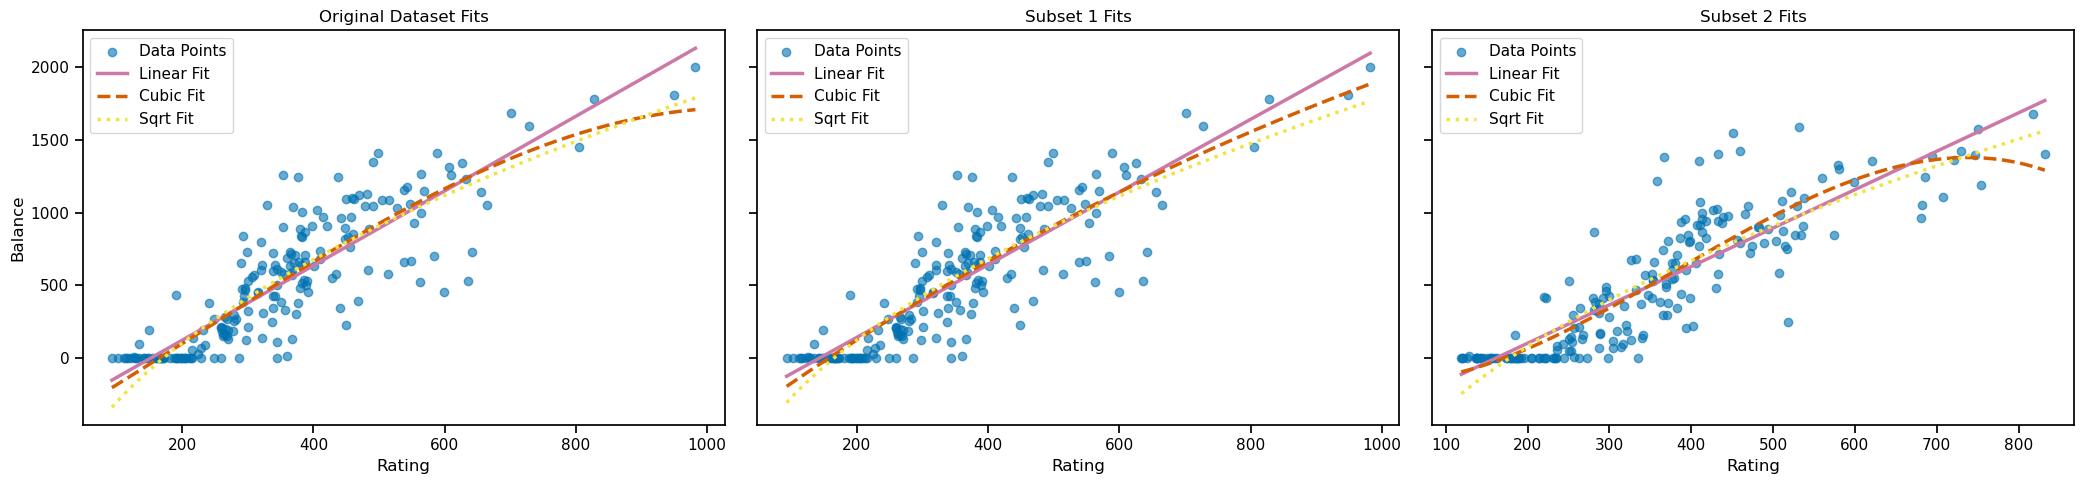

In [13]:
# Generate a range of x values for plotting the fitted curves
x_range1 = np.linspace(xdata1.min(), xdata1.max(), len(xdata1))
x_range2 = np.linspace(xdata2.min(), xdata2.max(), len(xdata2))

# Calculate the fitted y values for the plotting range
y_linear_fit_1 = linear_eq(x_range1, *linear_params1)
y_cubic_fit_1 = cubic_eq(x_range1, *cubic_params1)
y_sqrt_fit_1 = sqrt_eq(x_range1, *sqrt_params1)

y_linear_fit_2 = linear_eq(x_range2, *linear_params2)
y_cubic_fit_2 = cubic_eq(x_range2, *cubic_params2)
y_sqrt_fit_2 = sqrt_eq(x_range2, *sqrt_params2)


# Plotting
fig, axs = plt.subplots(1, 3, figsize=(21, 5), sharey=True)

# Plot for the original dataset
axs[0].scatter(xdata1, ydata1, color = scolor[2],label='Data Points', alpha=0.6)
axs[0].plot(x_fit, y_linear_fit, linestyle = '-', linewidth =2.5, color=scolor[0],label='Linear Fit')
axs[0].plot(x_fit, y_cubic_fit, linestyle = '--', linewidth =2.5, color=scolor[1], label='Cubic Fit')
axs[0].plot(x_fit, y_sqrt_fit, linestyle = ':', linewidth =2.5, color=scolor[3], label='Sqrt Fit')
axs[0].set_title('Original Dataset Fits')
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('Balance')
axs[0].legend()

# Plot for Subset 1
axs[1].scatter(xdata1, ydata1, color = scolor[2],label='Data Points', alpha=0.6)
axs[1].plot(x_range1, y_linear_fit_1, linestyle = '-', linewidth =2.5, color=scolor[0],label='Linear Fit')
axs[1].plot(x_range1, y_cubic_fit_1, linestyle = '--', linewidth =2.5, color=scolor[1],label='Cubic Fit')
axs[1].plot(x_range1, y_sqrt_fit_1, linestyle = ':', linewidth =2.5, color=scolor[3],label='Sqrt Fit')
axs[1].set_title('Subset 1 Fits')
axs[1].set_xlabel('Rating')
axs[1].legend()

# Plot for Subset 2
axs[2].scatter(xdata2, ydata2, color = scolor[2], label='Data Points', alpha=0.6)
axs[2].plot(x_range2, y_linear_fit_2, linestyle = '-', linewidth =2.5, color=scolor[0],label='Linear Fit')
axs[2].plot(x_range2, y_cubic_fit_2, linestyle = '--', linewidth =2.5, color=scolor[1],label='Cubic Fit')
axs[2].plot(x_range2, y_sqrt_fit_2, linestyle = ':', linewidth =2.5, color=scolor[3],label='Sqrt Fit')
axs[2].set_title('Subset 2 Fits')
axs[2].set_xlabel('Rating')
axs[2].legend()

plt.tight_layout()


&#9989; **Read this** Let's compare the metrics now. 

Text(0.5, 1.0, 'Metrics for Subset 2')

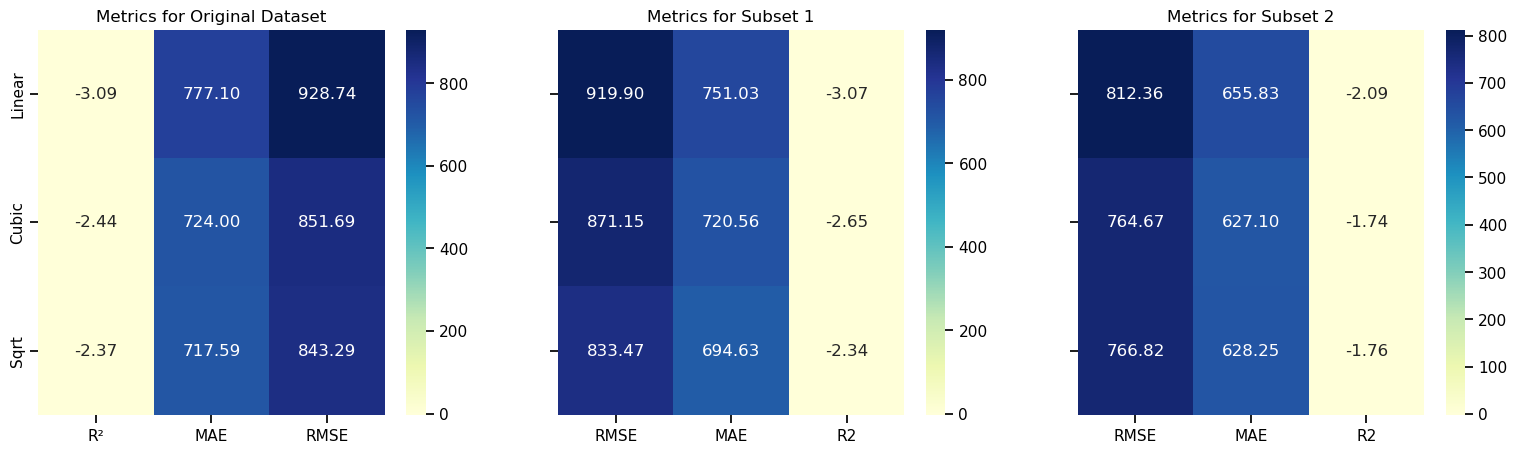

In [14]:
# Metrics for Subset 1
metrics_1 = {
    'Linear': {
        'RMSE': calculate_rmse(ydata1, y_linear_fit_1),
        'MAE': calculate_mae(ydata1, y_linear_fit_1),
        'R2': calculate_r_squared(ydata1, y_linear_fit_1)
    },
    'Cubic': {
        'RMSE': calculate_rmse(ydata1, y_cubic_fit_1),
        'MAE': calculate_mae(ydata1, y_cubic_fit_1),
        'R2': calculate_r_squared(ydata1, y_cubic_fit_1)
    },
    'Sqrt': {
        'RMSE': calculate_rmse(ydata1, y_sqrt_fit_1),
        'MAE': calculate_mae(ydata1, y_sqrt_fit_1),
        'R2': calculate_r_squared(ydata1, y_sqrt_fit_1)
    }
}

# Metrics for Subset 2
metrics_2 = {
    'Linear': {
        'RMSE': calculate_rmse(ydata2, y_linear_fit_2),
        'MAE': calculate_mae(ydata2, y_linear_fit_2),
        'R2': calculate_r_squared(ydata2, y_linear_fit_2)
    },
    'Cubic': {
        'RMSE': calculate_rmse(ydata2, y_cubic_fit_2),
        'MAE': calculate_mae(ydata2, y_cubic_fit_2),
        'R2': calculate_r_squared(ydata2, y_cubic_fit_2)
    },
    'Sqrt': {
        'RMSE': calculate_rmse(ydata2, y_sqrt_fit_2),
        'MAE': calculate_mae(ydata2, y_sqrt_fit_2),
        'R2': calculate_r_squared(ydata2, y_sqrt_fit_2)
    }
}

# Convert the metrics dictionaries to DataFrames for heatmap plotting
metrics_df_1 = pd.DataFrame(metrics_1).T
metrics_df_2 = pd.DataFrame(metrics_2).T

# Plotting heatmaps
fig, ax = plt.subplots(1, 3, figsize=(19, 5), sharey=True)
sns.heatmap(metrics_df, annot=True, cmap="YlGnBu", fmt=".2f", ax = ax[0])
ax[0].set_title('Metrics for Original Dataset')
sns.heatmap(metrics_df_1, annot=True, cmap="YlGnBu",  fmt=".2f", ax=ax[1])
ax[1].set_title('Metrics for Subset 1')
sns.heatmap(metrics_df_2, annot=True, cmap="YlGnBu",  fmt=".2f", ax=ax[2])
ax[2].set_title('Metrics for Subset 2')


&#9989; **Read this** Let's compare the values of the parameters now. The next code cells puts all the parameters into tables and plots them as heatmaps.

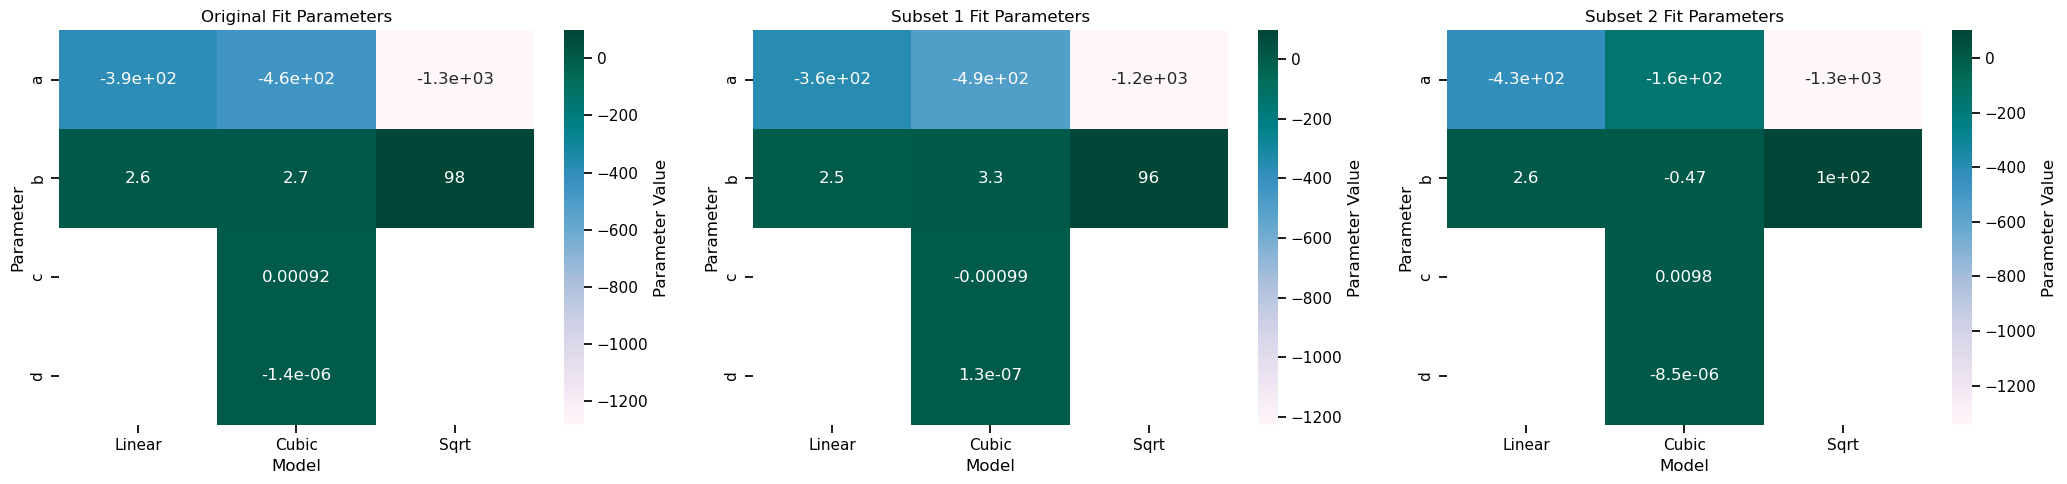

In [15]:
# Create DataFrames from the parameters of the original data (without splitting)
params_df = pd.DataFrame({
    'Linear': np.append(linear_params, [np.nan, np.nan]), # Append NaN for the missing cubic parameter in the linear model for alignment
    'Cubic': cubic_params,
    'Sqrt': np.append(sqrt_params, [np.nan, np.nan])
}, index=['a', 'b', 'c', 'd'])


# Create DataFrames from the parameters of the first subset
params_df_1 = pd.DataFrame({
    'Linear': np.append(linear_params1, [np.nan, np.nan]), # Append NaN for the missing cubic parameter in the linear model for alignment
    'Cubic': cubic_params1,
    'Sqrt': np.append(sqrt_params1, [np.nan, np.nan]), # Append NaN for the missing cubic parameter in the linear model for alignment
}, index=['a', 'b', 'c', 'd'])

# Create DataFrames from the parameters of the second subset
params_df_2 = pd.DataFrame({
    'Linear': np.append(linear_params2, [np.nan, np.nan]), # Append NaN for the missing cubic parameter in the linear model for alignment
    'Cubic': cubic_params2,
    'Sqrt': np.append(sqrt_params2, [np.nan, np.nan]), # Append NaN for the missing cubic parameter in the linear model for alignment
}, index=['a', 'b', 'c', 'd'])


# Adjusting the DataFrame for better readability
params_df.index.name = 'Parameter'
params_df_1.index.name = 'Parameter'
params_df_2.index.name = 'Parameter'

params_df.columns.name = 'Model'
params_df_1.columns.name = 'Model'
params_df_2.columns.name = 'Model'

# Plotting the heatmaps
fig, axs = plt.subplots(1, 3, figsize=(21, 5))

sns.heatmap(params_df, annot=True, cmap='PuBuGn', ax=axs[0], cbar_kws={'label': 'Parameter Value'})
axs[0].set_title('Original Fit Parameters')

sns.heatmap(params_df_1, annot=True, cmap='PuBuGn', ax=axs[1], cbar_kws={'label': 'Parameter Value'})
axs[1].set_title('Subset 1 Fit Parameters')

sns.heatmap(params_df_2, annot=True, cmap='PuBuGn', ax=axs[2], cbar_kws={'label': 'Parameter Value'})
axs[2].set_title('Subset 2 Fit Parameters')

plt.tight_layout()



&#9989; **Questions (6 points)** Now you have the parameters, the plots, and the metrics. What is your conclusion? 

1. Why do you think the cubic parameters of subset 1 and subset 2 are different? What causes them to be different? What does this imply for the reliability of the cubic model?
2. Which model is better suited for predicting a person's credit card debt given their credit score? Explain. You cannot say they are all bad, you must choose.


<font size=8 color="#009600">&#9998;</font> **Answer:**

1. When `curve_fit()` is used to generate parameters, the parameters depend on the data we provide to the function. When we subset the data into two parts, the parameters created were modeled based off the new data that was provided to generate a best fit to that specific dataset. So naturally, for all models, the parameters will change. However, about the magnitude of said change, there are more variables at play in the cubic model as compared to the linear model. These different parameters change differently when modeled with highly specific data, as compared to the linear model with not many parameters at play, leading to a more or less similar set of parameters for specific subsets. In terms of reliability, the cubic model is a terrible choice. Even if it is able to fit the data points more accurately due to the sheer number of parameters affecting the model, the fluctuations within the subsets shows the unstability of the model and its lack of resistance to outliers. Essentially, the replacement breakdown point of this model is very less.
2. With the exception of subset 1, the squared root model provided smaller errors and less negative coefficients of determination, leading me to choose this model. Even in the plots, taking the linear model completely out of the question since its heading in a completely different direction due to its lack of mobility, the squared model has fared better compared to the cubic model in terms of relative proximity with the data points. It is a close race for least worst between the squared and cubic models, and despite the cubic model faring well in subset 1, the narrow majority is earned by the squared model. Also, the cubic model is tilting downwards, a weird trend not really consistent with the idea behind the relation between the two factors here. It is quite possible that the cubic model got lucky with the data in subset 1.

### BEFORE MOVING TO THE NEXT PROBLEM

The above problem was a walkthrough of some of the decisions you will have to make if you choose to do a project in data science. The problem itself does not constitute a satisfactory (100 points) example of a CMSE201 project. Why? The EDA is not complete. The dataset has categorical data that can be useful for improving your model. Questions that you might ask are: Is ethnicity a better descriptor than education level or age? Meaning, how do the parameters in my models change between different ethnicities or education level or age or the number of cards? Do students have a higher credit card debt compared to non students? What about gender? 

The next code cells provide some code to make nice plots and extract information. This is to help you focus on the questions in your project without worrying too much about the code. Furthermore, don't forget that chatGPT can write most of this code for you. In fact the above code was all written with chatGPT. 


&#9989; **Read this** As mentioned above the data is divided into two types: numerical and [categorical](http://www.stat.yale.edu/Courses/1997-98/101/catdat.htm). Scatter plots and normal line plots work well for finding relationship between numerical data columns, while histograms, pie charts, box plots and violin plots work well for categorical data. [Here](https://seaborn.pydata.org/tutorial/categorical.html) is `seaborn`'s tutorial on categorical plots. One type of plot that is missing from that webpage is pie charts. These are a good way to represent the percentage of each category in our dataset. 

The next code cell creates pie chart for all the categorical columns. 

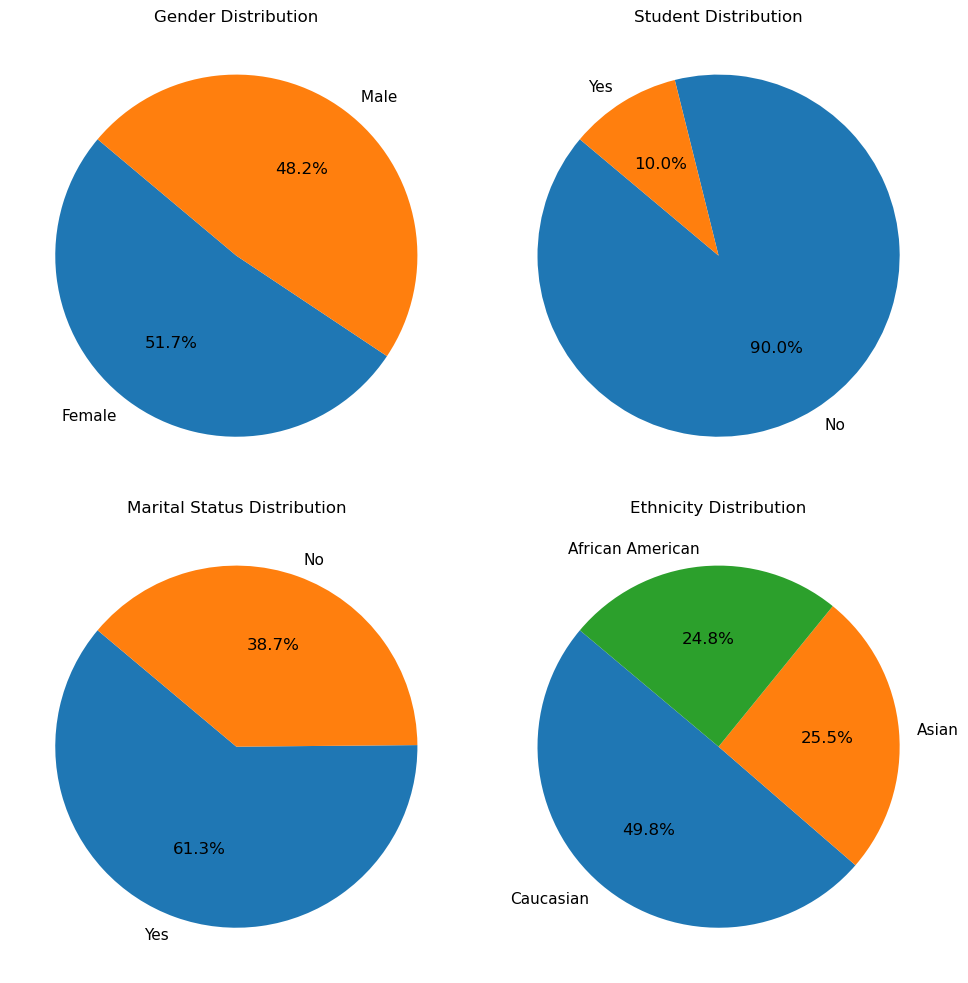

In [16]:
# Creating a figure and a 2x2 grid of subplots for displaying pie charts of categorical variables
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Gender Distribution
# Counting the number of occurrences for each gender category
gender_counts = credit_data['Gender'].value_counts()
# Creating a pie chart for Gender distribution in the first subplot
axes[0, 0].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
# Setting the title for the Gender distribution pie chart
axes[0, 0].set_title('Gender Distribution')

# Student Distribution
# Counting the number of occurrences for each student status category
student_counts = credit_data['Student'].value_counts()
# Creating a pie chart for Student distribution in the second subplot
axes[0, 1].pie(student_counts, labels=student_counts.index, autopct='%1.1f%%', startangle=140)
# Setting the title for the Student distribution pie chart
axes[0, 1].set_title('Student Distribution')

# Marital Status Distribution
# Counting the number of occurrences for each marital status category
married_counts = credit_data['Married'].value_counts()
# Creating a pie chart for Marital Status distribution in the third subplot
axes[1, 0].pie(married_counts, labels=married_counts.index, autopct='%1.1f%%', startangle=140)
# Setting the title for the Marital Status distribution pie chart
axes[1, 0].set_title('Marital Status Distribution')

# Ethnicity Distribution
# Counting the number of occurrences for each ethnicity category
ethnicity_counts = credit_data['Ethnicity'].value_counts()
# Creating a pie chart for Ethnicity distribution in the fourth subplot
axes[1, 1].pie(ethnicity_counts, labels=ethnicity_counts.index, autopct='%1.1f%%', startangle=140)
# Setting the title for the Ethnicity distribution pie chart
axes[1, 1].set_title('Ethnicity Distribution')

# Adjusting the layout to prevent overlap of subplot elements
plt.tight_layout()
# Displaying the figure with the pie charts
plt.show()


&#9989; **Read this** The next code cell divides the dataset based on the choices of each categorical column. Then makes correlation matrices for each and plots them with a heatmap. What do you notice?

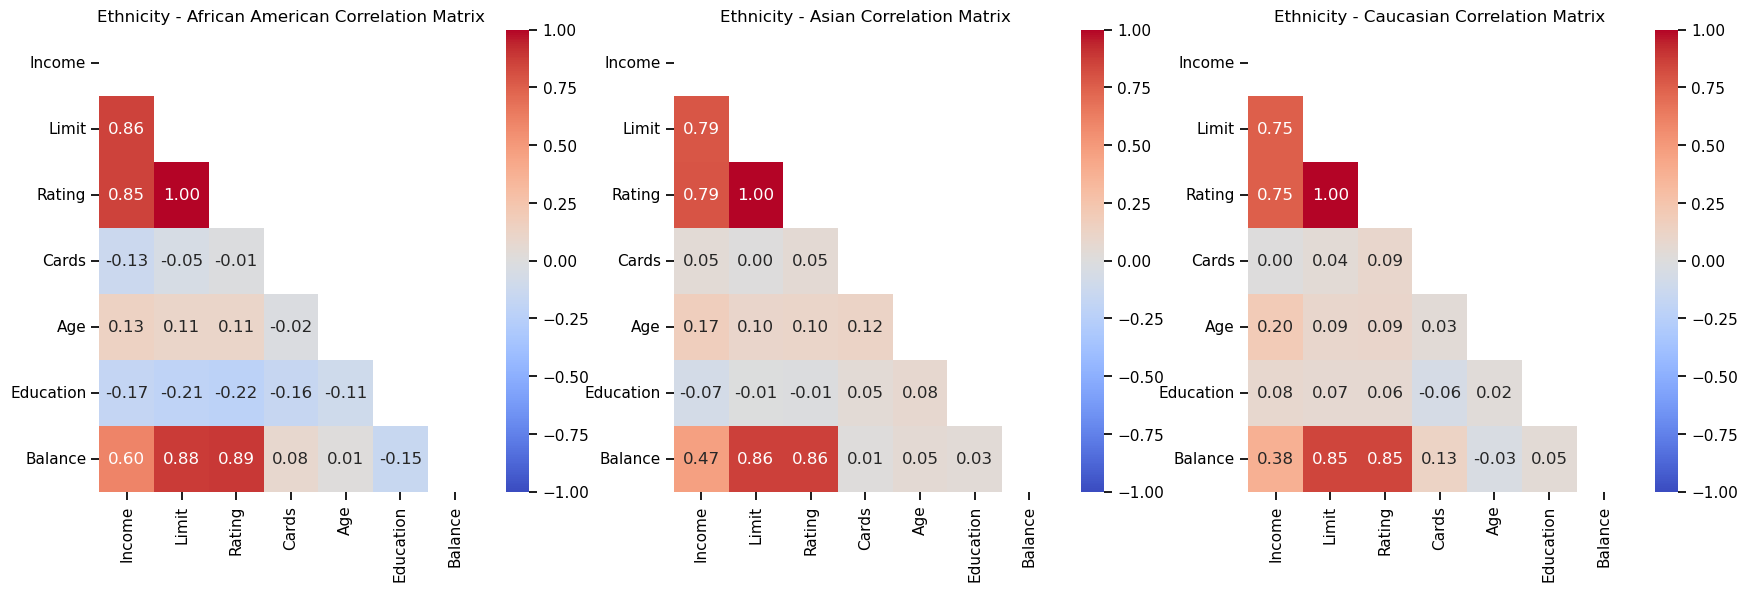

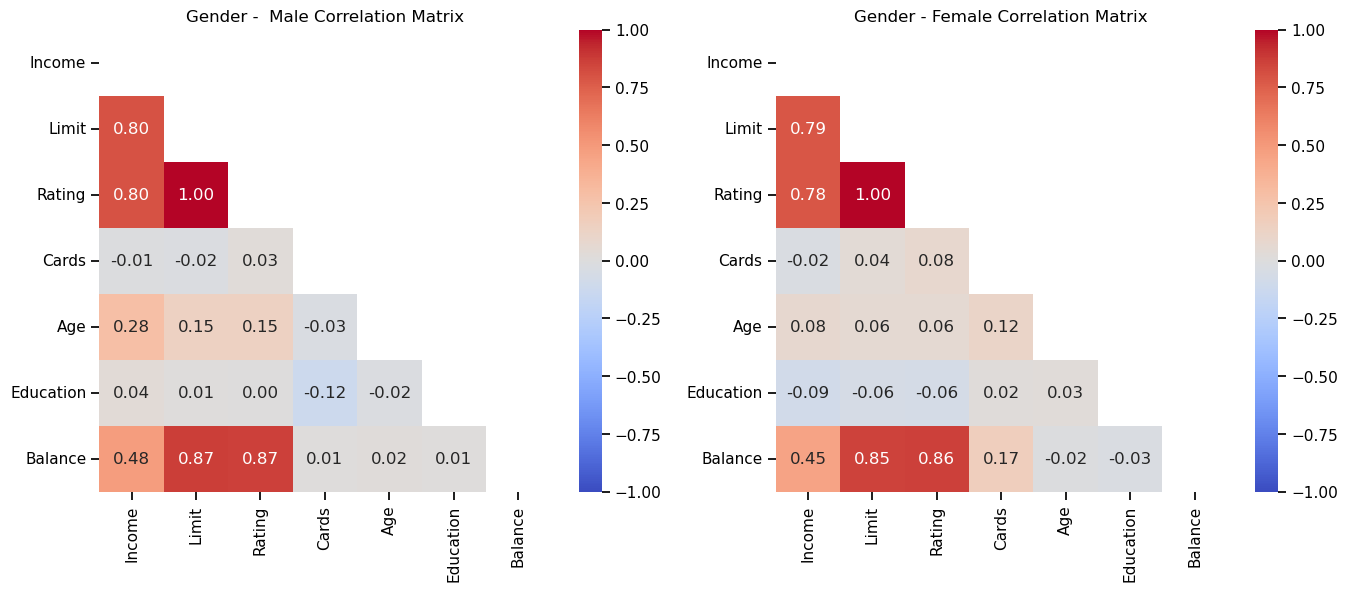

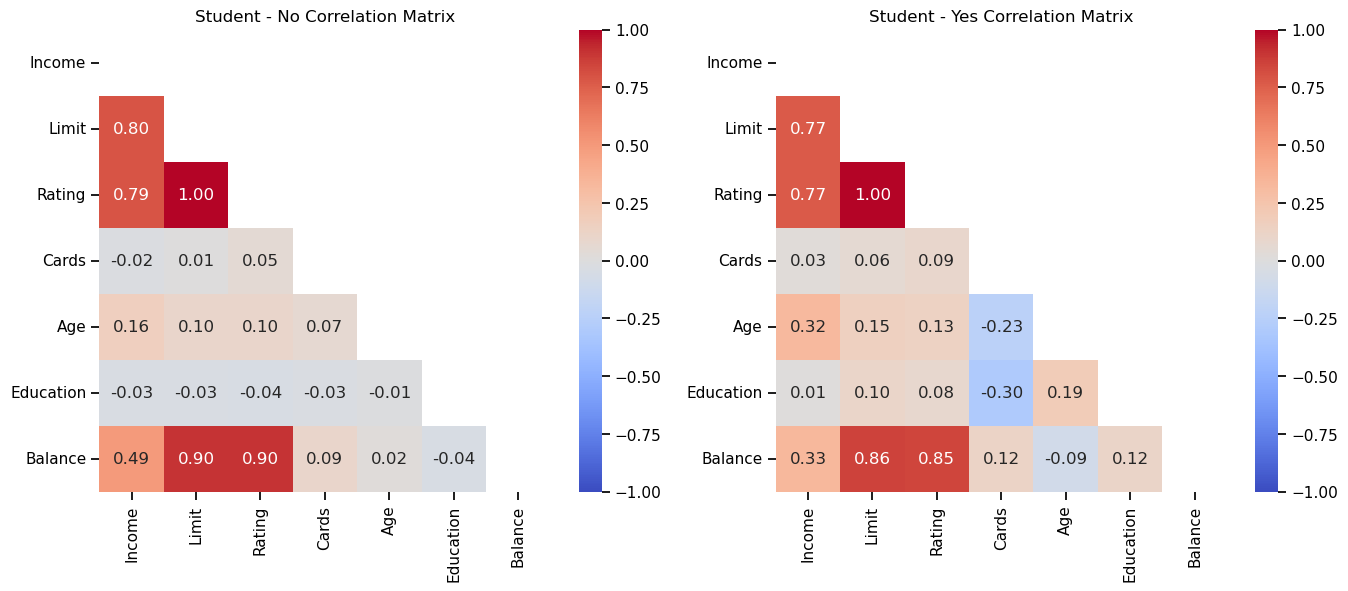

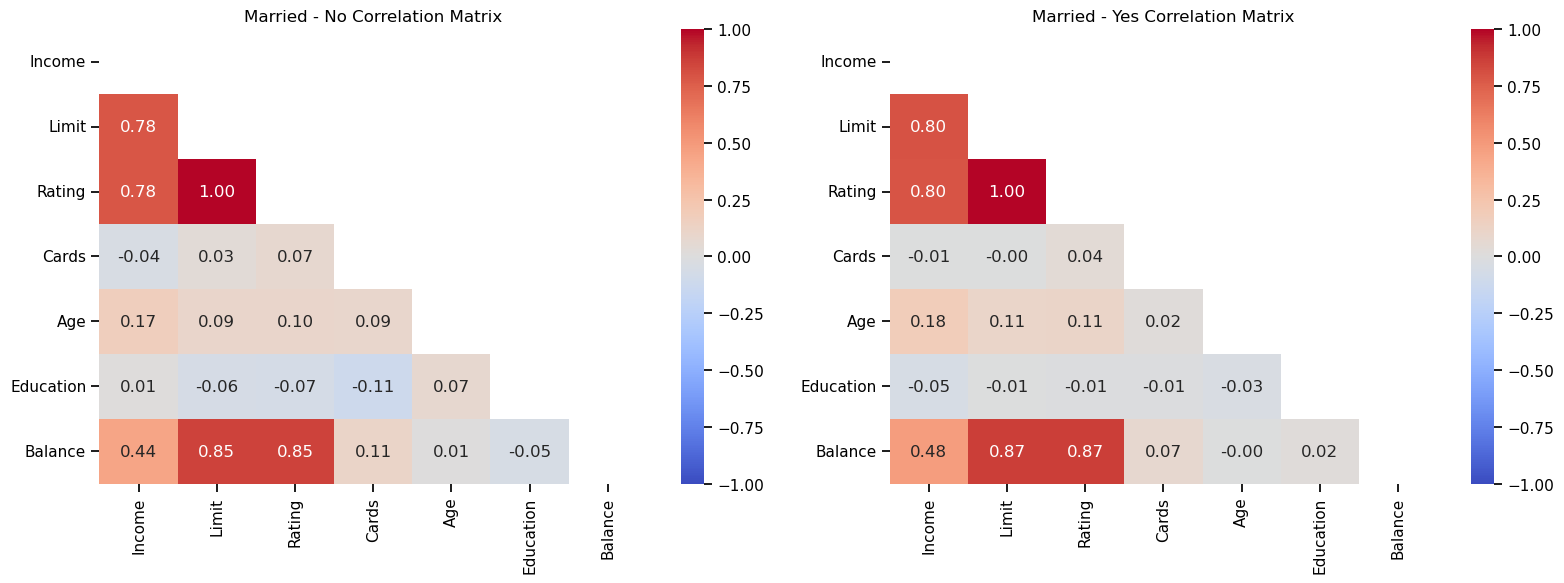

In [17]:
# List of categorical columns to group by
categorical_columns = ["Ethnicity", 'Gender', 'Student', 'Married']

# Loop through each categorical column to group the dataset, calculate correlation matrices, and plot
for i, column in enumerate(categorical_columns):
    # Group the dataset by the current categorical column
    groups = credit_df.groupby(column)
    num_groups = len(groups)
    
    # Initialize a figure for the plots
    figsize = (21, 6) if i ==0 else (16,6)
    fig, axes = plt.subplots(1, num_groups, figsize=figsize)
    
    # Create subplots for each group within the current categorical column
    for j, (group_name, group_df) in enumerate(groups):
        # Calculate the correlation matrix for the current group
        corr_matrix = group_df.corr(numeric_only = True)

        # Create a mask to hide the upper triangle
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        # Plotting the correlation matrix for the current group in the corresponding subplot
        ax = sns.heatmap(corr_matrix, 
                         annot=True, # put the correlation coefficient in the plot
                         vmin = -1, vmax = 1, # set the limits equal for all the plots
                         fmt=".2f", # only 2 decimal digits
                         cmap='coolwarm', # color map
                         ax=axes[j], # Position in the figure
                         mask=mask)
        ax.set_title(f'{column} - {group_name} Correlation Matrix')

plt.tight_layout()

---
## Part 2. Fitting a model to data with `curve_fit` and visualizing the results (16 points)

We have studied building ordinary differential equations (ODEs) and solving them by `solve_ivp`. Using `curve_fit` to fit the numerical solution can always inspire us to find the true solution. 
Now we have the following differential equation:
$$ \frac{dv}{dt} =7\sin(3t)dt$$
with the initial $v(0) =0.0$. Using the code below you can find the numerical solution `y_values` on the time interval $[0,30]$. Try to fit these data and test your final analytic solution.

Text(0, 0.5, 'y_solution')

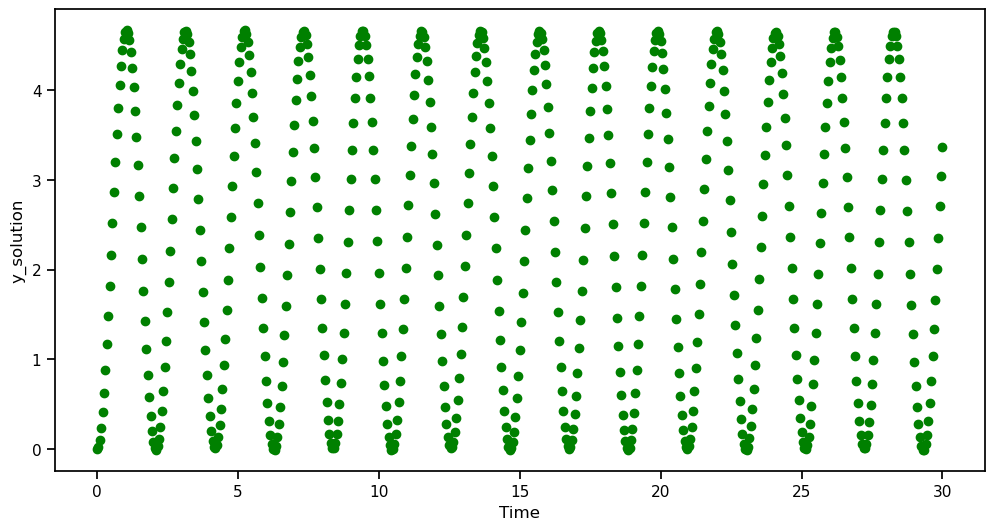

In [18]:
## DO NOT DELETE THE PROVIDED LINES OF CODE

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import solve_ivp

# Define a function that computes the derivatives
def derivatives(t, curr_vals):
    v = curr_vals
    
    dvdt = 7*np.sin(3*t)
    
    #return the derivatives
    return dvdt

# Define initial conditions
t = 0.0
v = 0.0

# Define the final time and the time step
final_time = 30.0
delta_t = 0.05

# Define some lists to store values
time = []
y_values = []

    
# Define the time array
time = np.arange(0, final_time + delta_t, delta_t)

# Store the initial values in a list
init = [v]

# Solve the odes with solve_ivp
sol = solve_ivp(derivatives, (t,final_time),init,t_eval = time)

# length = sol.y[0,:]
y_values = sol.y[0,:]
    
# Make a plot of the result
plt.figure(figsize = (12,6))
plt.scatter(time,y_values, color="green")
plt.xlabel("Time")
plt.ylabel("y_solution")

&#9989;&nbsp; **Question 2.1 (8 points):** Using the time array `time` and numerical solution `y_values` data and provided model below, use `curve_fit` to find best fit parameters for *a, b,* and *c*. Make sure you give `curve_fit` a good starting point for finding the best fit parameters using the `p0` argument and these starting values:
* a = 7
* b = 3
* c = 0



In [19]:
# Will need to use NumPy for the function
import numpy as np

# Will need to import curve_fit from SciPy
from scipy.optimize import curve_fit

# This function calculates volts corresponding to the time for a sound wave
def cos_wave(t,a,b,c):
    return a*np.cos(b*t)+c

In [20]:
# Initializing variables for initial values

a = 7
b = 3
c = 0

# Conducting the curve-fitting operation on the cos_wave() function: fit parameters and the co-variance (error) matrix are obtained in sequence
# The error matrix can be ignored.

fit_parameters, pcov_ignore = curve_fit(cos_wave, time, y_values, p0 = [a, b, c])

# Displaying the parameters for the line of best fit

print(fit_parameters)

[-2.3344087   3.00005645  2.32696411]


&#9989;&nbsp; **Question 2.2 (8 points)** Now that you have a set of best-fit parameters, **use those parameters to calculate the expected model values and plot the expected model values on top of the actual data values**. Make sure to label your axes and include a legend to communicate what parts of the plot correspond to the model versus the data.


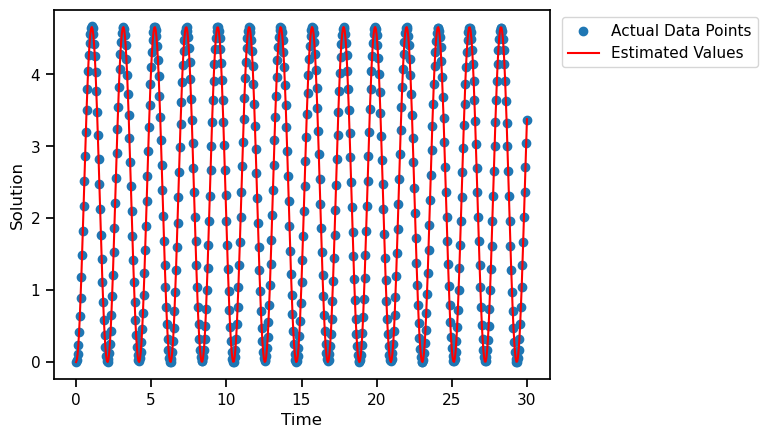

In [21]:
# Using curve-fit parameters in the function to generate expected model y-values for the line of best fit

y_bestfit = cos_wave(time, fit_parameters[0], fit_parameters[1], fit_parameters[2])

# Generating the plot for expected values and the actual data points

plt.scatter(time, y_values, label = "Actual Data Points") # a scatter plot for the actual data
plt.plot(time, y_bestfit, "red", label = "Estimated Values") # a line plot for the line of best fit
plt.xlabel("Time") # x-axis label
plt.ylabel("Solution") # y-axis label
plt.legend(bbox_to_anchor=(1.01, 1)) # using bbox_to_anchor attribute to place the legend outside the plot
plt.show()
# Re: Legend Location Outside the Plot; Source: https://www.squash.io/how-to-position-the-legend-outside-the-plot-in-matplotlib/#google_vignette

---
# Part 3: Modeling a system using `solve_ivp` (35 points)

In part 2, we used `solve_ivp` to solve a single differential equation. Now, we will use this technique to solve a differential system.

&#9989;&nbsp; **Question 3.1 (25 points)**: The SIR epidemic model is one of the simplest compartmental models, and many models are derivatives of this basic form(https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology). The model consists of three compartments: 
The number of susceptible individuals (S), the number of infectious individuals (I), and the number of removed (and immune) or deceased individuals (R). When we account for the vaccination impacts on the model, we have the following SIRVI model:
$$ \frac{dS}{dt} = -\beta SI -\mu S, $$
$$ \frac{dI}{dt} = \beta SI +\alpha VI -\gamma I, $$
$$ \frac{dV}{dt} = \mu S -\alpha VI, $$
$$ \frac{dR}{dt} = \gamma I ,$$

where $V$ is the number of vaccinated individuals, the parameters $\beta$ represents the infectious rate of susceptibles, $\gamma$ is the recovery rate, $\mu$ is the vaccine rate of susceptibles, and $\alpha$ is the infectious rate of vaccinated. We assume will use day as our unit of time, $t$. This means that, for example,$t=2$ would be 2 days.

Solve this SIRV system using `solve_ivp`. Assuming the parameters $\alpha =0.2, \beta =0.01, \gamma = 0.5$, and $\mu = 0.4$ with the following initial conditions:

* $S(0) = 130$
* $I(0) = 40$
* $V(0) = 50$
* $R(0) = 0$
  
Evolve the model for 15 days using a timestep of $\Delta t = 0.01$ days.

**Code you need to write to solve this problem**:
1. A function that takes in a set of time values as well as the current values for $S$, $I$, $V$, $R$ and **returns** the derivatives for each variable, $\frac{dS}{dt}$, $\frac{dI}{dt}$, $\frac{dV}{dt}$,and $\frac{dR}{dt}$. This would be your "derivatives" function that `solve_ivp` needs.(**7pts**)
2. A set of variables for storing your initial conditions, $S_0$, $I_0$, $V_0$, and $R_0$, set to the correct initial values.(**5pts**)
3. A variable that stores all the times for which you want to solve the system of ODEs, you can generate these times using `np.arange()`. The times should match the time range and timestep size specified above.(**2pts**)
4. Code that calls `solve_ivp` using all of the appropriate arguments and stores the result. (**5pts**)
5. Code that unpacks the solution so that you can plot it.(**6pts**)

**Note**: you will not need the "`args`" argument for `solve_ivp` for this case because any model parameters that might be needed for this system are provided directly as numbers in the set of  ODEs include above.

In [22]:
# Importing the relevant packages and modules

from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

**1**. Define a function that takes in a set of time values as well as the current values for $S$, $I$, $V$, $R$ and **returns** the derivatives for each variable, $\frac{dS}{dt}$, $\frac{dI}{dt}$, $\frac{dV}{dt}$,and $\frac{dR}{dt}$. This would be your "derivatives" function that `solve_ivp` needs.(**7pts**)

In [23]:
def deriv_SIR(time_values, current_values):
    
    # Defining parameters
    
    alpha = 0.2
    beta = 0.01
    gamma = 0.5
    mu = 0.4
    
    # Extracting current values
    
    S, I, V, R = current_values
    
    # Defining ODEs
    
    dSdt = (-beta * S * I) - (mu * S)
    dIdt = (beta * S * I) + (alpha * V * I) - (gamma * I)
    dVdt = (mu * S) - (alpha * V * I)
    dRdt = gamma * I
    
    return dSdt, dIdt, dVdt, dRdt

**2**. Store a list of variables for your initial conditions, $S_0$, $I_0$, $V_0$, and $R_0$, set to the correct initial values.(**5pts**)

In [24]:
# Setting the correct initial values

S0 = 130
I0 = 40
V0 = 50
R0 = 0

# Creating a list for use in solve_ivp

initial_values = [S0, I0, V0, R0]

**3**. Create a variable that stores all the times for which you want to solve the system of ODEs, you can generate these times using `np.arange()`. The times should match the time range and timestep size specified above. Remember: the start value of np.arange is inclusive but goes up to but does not include the end value.(**2pts**)

In [25]:
# Setting the time values

dt = 0.01
tmax = 15

times = np.arange(0, tmax + dt, dt) # start - 0; end - end + step

**4**. Code that calls `solve_ivp` using all of the appropriate arguments and stores the result. (**5pts**)

In [26]:
# Solving the ODEs with solve_ivp

solution = solve_ivp(deriv_SIR, (0,tmax), initial_values, t_eval = times)

**5**. Code that unpacks the solution so that you can plot it.(**6pts**)

In [27]:
# Unpacking the solutions of the ODEs

S, I, V, R = solution.y
t = solution.t

&#9989;&nbsp; **Question 3.2 (10 points)**:
Now that you have a solution to the model, make a single plot that displays the evolution of all four variables, susceptible, infected , vaccinated, and removed individual number as a function time. Each line should be a different color and your plot should contain a $x$-axis label, a $y$-axis label, and a legend.

The points for this question are distributed as follows:
- **1.5pts**: susceptible individual number $S$
- **1.5pts**: infected individual number $I$
- **1.5pts**: vaccinated didividual number $V$
- **1.5pts**: removed didividual number $R$
- **1pt**: x axis label `Time in days`
- **1pt**: y axis label `Number of population`
- **1pt**: title `Population numbers over time`
- **1pt**: legend, with labels `Susceptible`, `Infected`,`Vaccinated`, and `Removed`

If all goes well, you should end up with something that looks like this:

![numerical](./numerical.png)

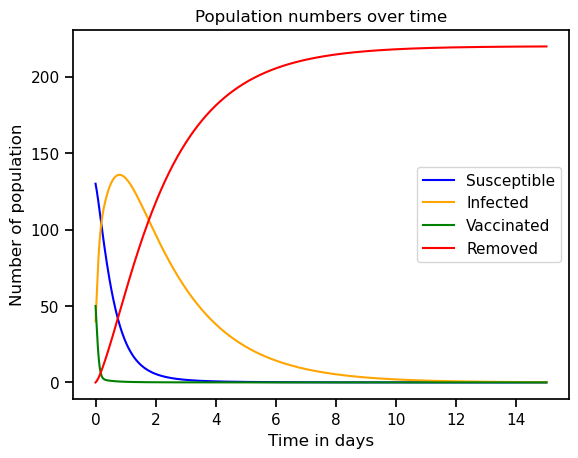

In [28]:
# Plotting the solutions

plt.plot(t, S, color = 'blue', label = 'Susceptible')
plt.plot(t, I, color = 'orange', label = 'Infected')
plt.plot(t, V, color = 'green', label = 'Vaccinated')
plt.plot(t, R, color = 'red', label = 'Removed')
plt.xlabel('Time in days')
plt.ylabel('Number of population')
plt.title('Population numbers over time')
plt.legend()
plt.show()

---

### Congratulations, you're done!

Submit this assignment by uploading it to the course Desire2Learn web page.  Go to the "Homework Assignments" folder, find the submission link for Homework 4, and upload it there.

&#169; 2024 Copyright the Department of Computational Mathematics, Science and Engineering.